In [77]:
import numpy as np
import time
import os
import pandas as pd
# from tqdm import tqdm
import seaborn as sns
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import cv2
from glob import glob

import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def load_data_to_df(path):

    imgs = []
    paths = []
    breed  = []
    height, width = [], []

    for folder in tqdm(glob(path)):
        img = cv2.imread(folder)
        imgs.append(img)
        paths.append(folder)
        height.append(img.shape[0])
        width.append(img.shape[1])
        breed.append(folder.split("/")[3].split("-", 1)[1])
    df = pd.DataFrame({'img' : imgs, 'path': paths, 'breed': breed, 'height': height, 'width': width})
    return df

In [3]:
df = load_data_to_df("../dataset/Images/*/*")

  0%|          | 0/20580 [00:00<?, ?it/s]

In [4]:
df.head()

img  \
0  [[[252, 255, 251], [107, 111, 105], [88, 90, 8...   
1  [[[225, 138, 196], [225, 138, 196], [224, 137,...   
2  [[[57, 87, 106], [57, 87, 106], [58, 87, 108],...   
3  [[[49, 49, 49], [43, 43, 43], [39, 39, 39], [4...   
4  [[[164, 194, 219], [166, 196, 221], [168, 198,...   

                                                path          breed  height  \
0  ../dataset/Images/n02109525-Saint_Bernard/n021...  Saint_Bernard     480   
1  ../dataset/Images/n02109525-Saint_Bernard/n021...  Saint_Bernard     333   
2  ../dataset/Images/n02109525-Saint_Bernard/n021...  Saint_Bernard     500   
3  ../dataset/Images/n02109525-Saint_Bernard/n021...  Saint_Bernard     375   
4  ../dataset/Images/n02109525-Saint_Bernard/n021...  Saint_Bernard     282   

   width  
0    393  
1    500  
2    333  
3    500  
4    290

Text(0.5, 1.0, 'Distribution of Dog breeds')

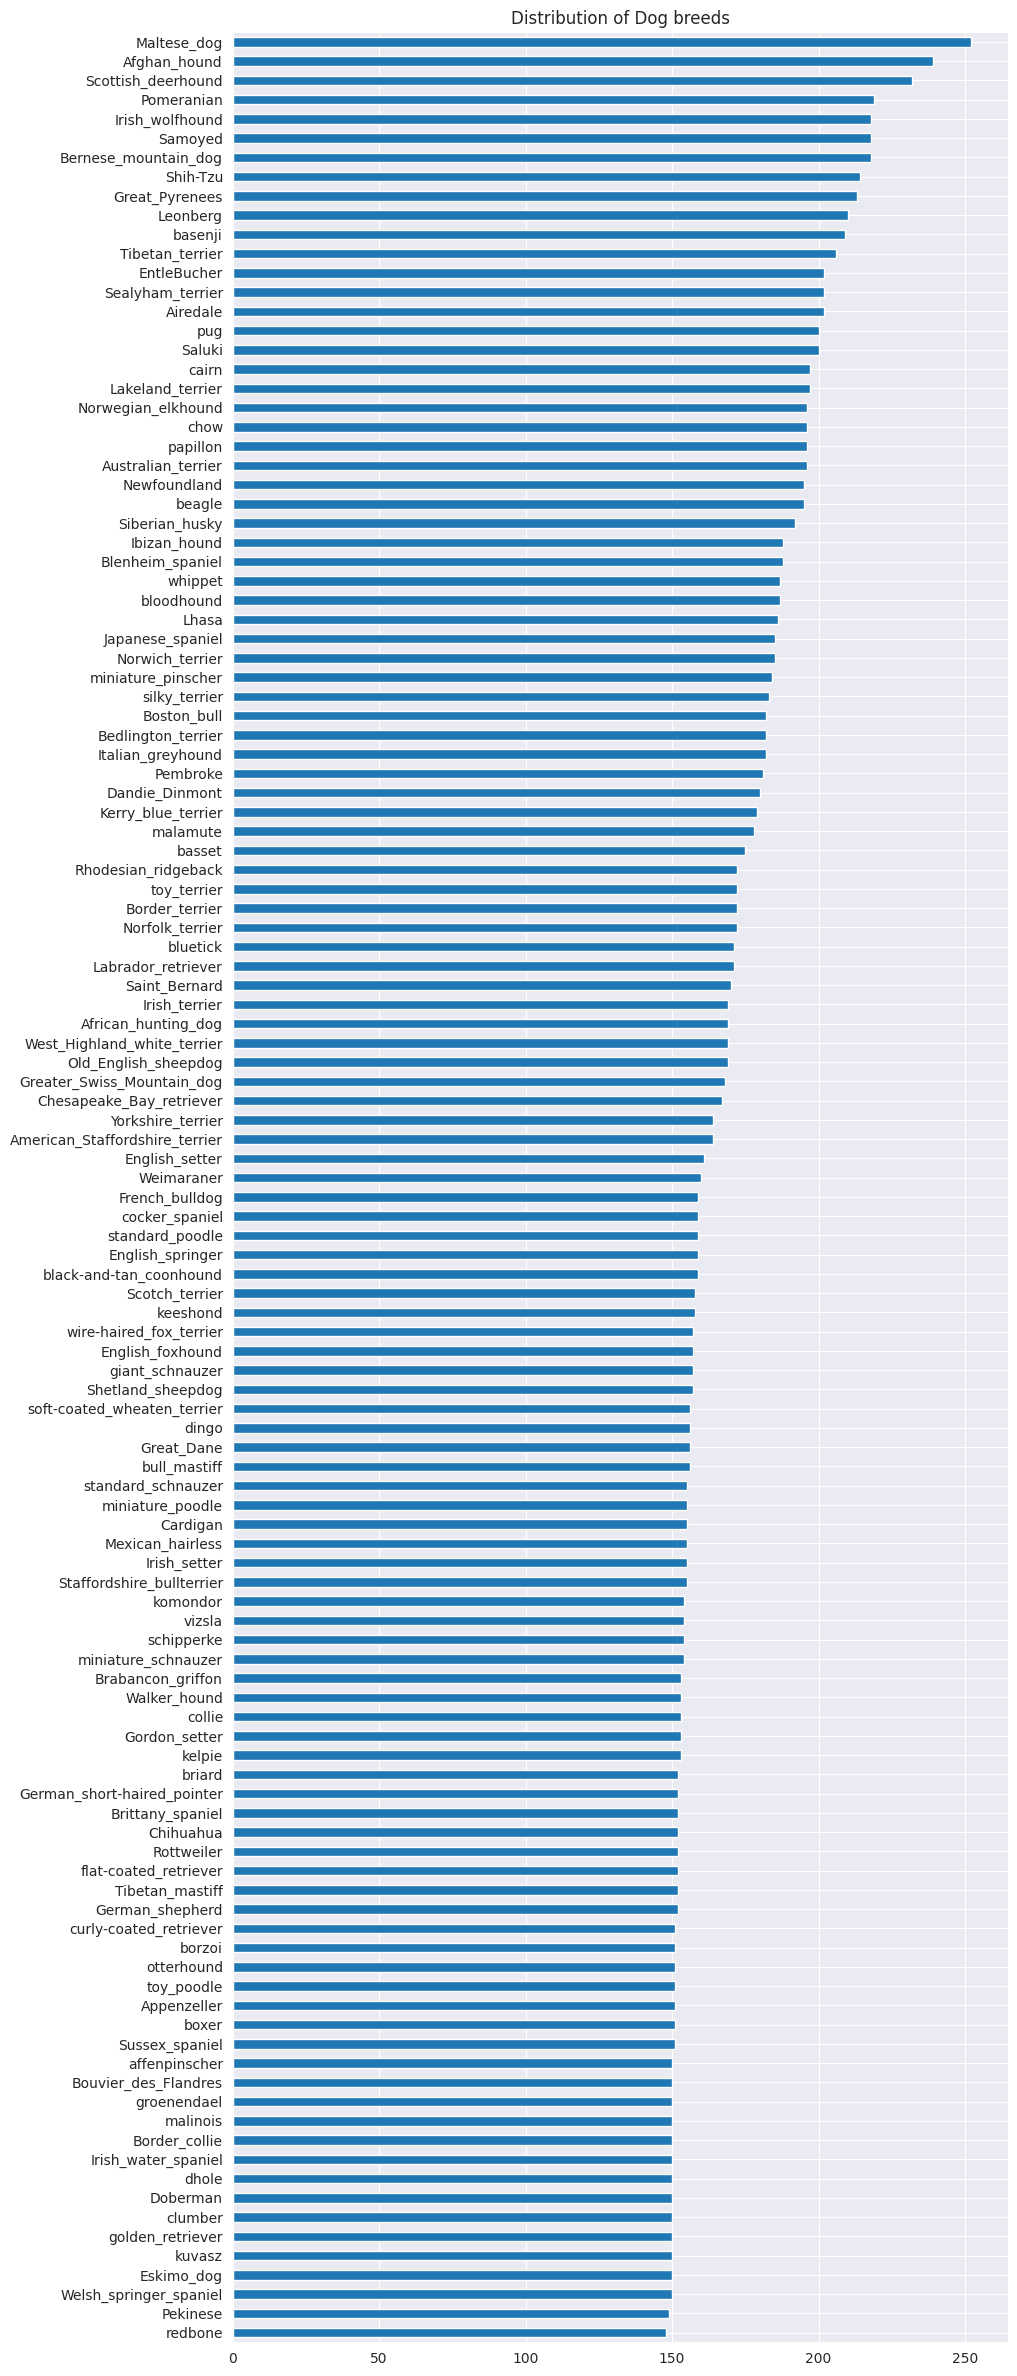

In [5]:
fig, ax = plt.subplots(figsize=(10,30))
df['breed'].value_counts().plot(ax=ax, kind='barh').invert_yaxis()
ax.set_title('Distribution of Dog breeds')

In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data, = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['breed'])

train_data, valid_data, = train_test_split(
    train_data, test_size=0.1, random_state=42, stratify=train_data['breed'])

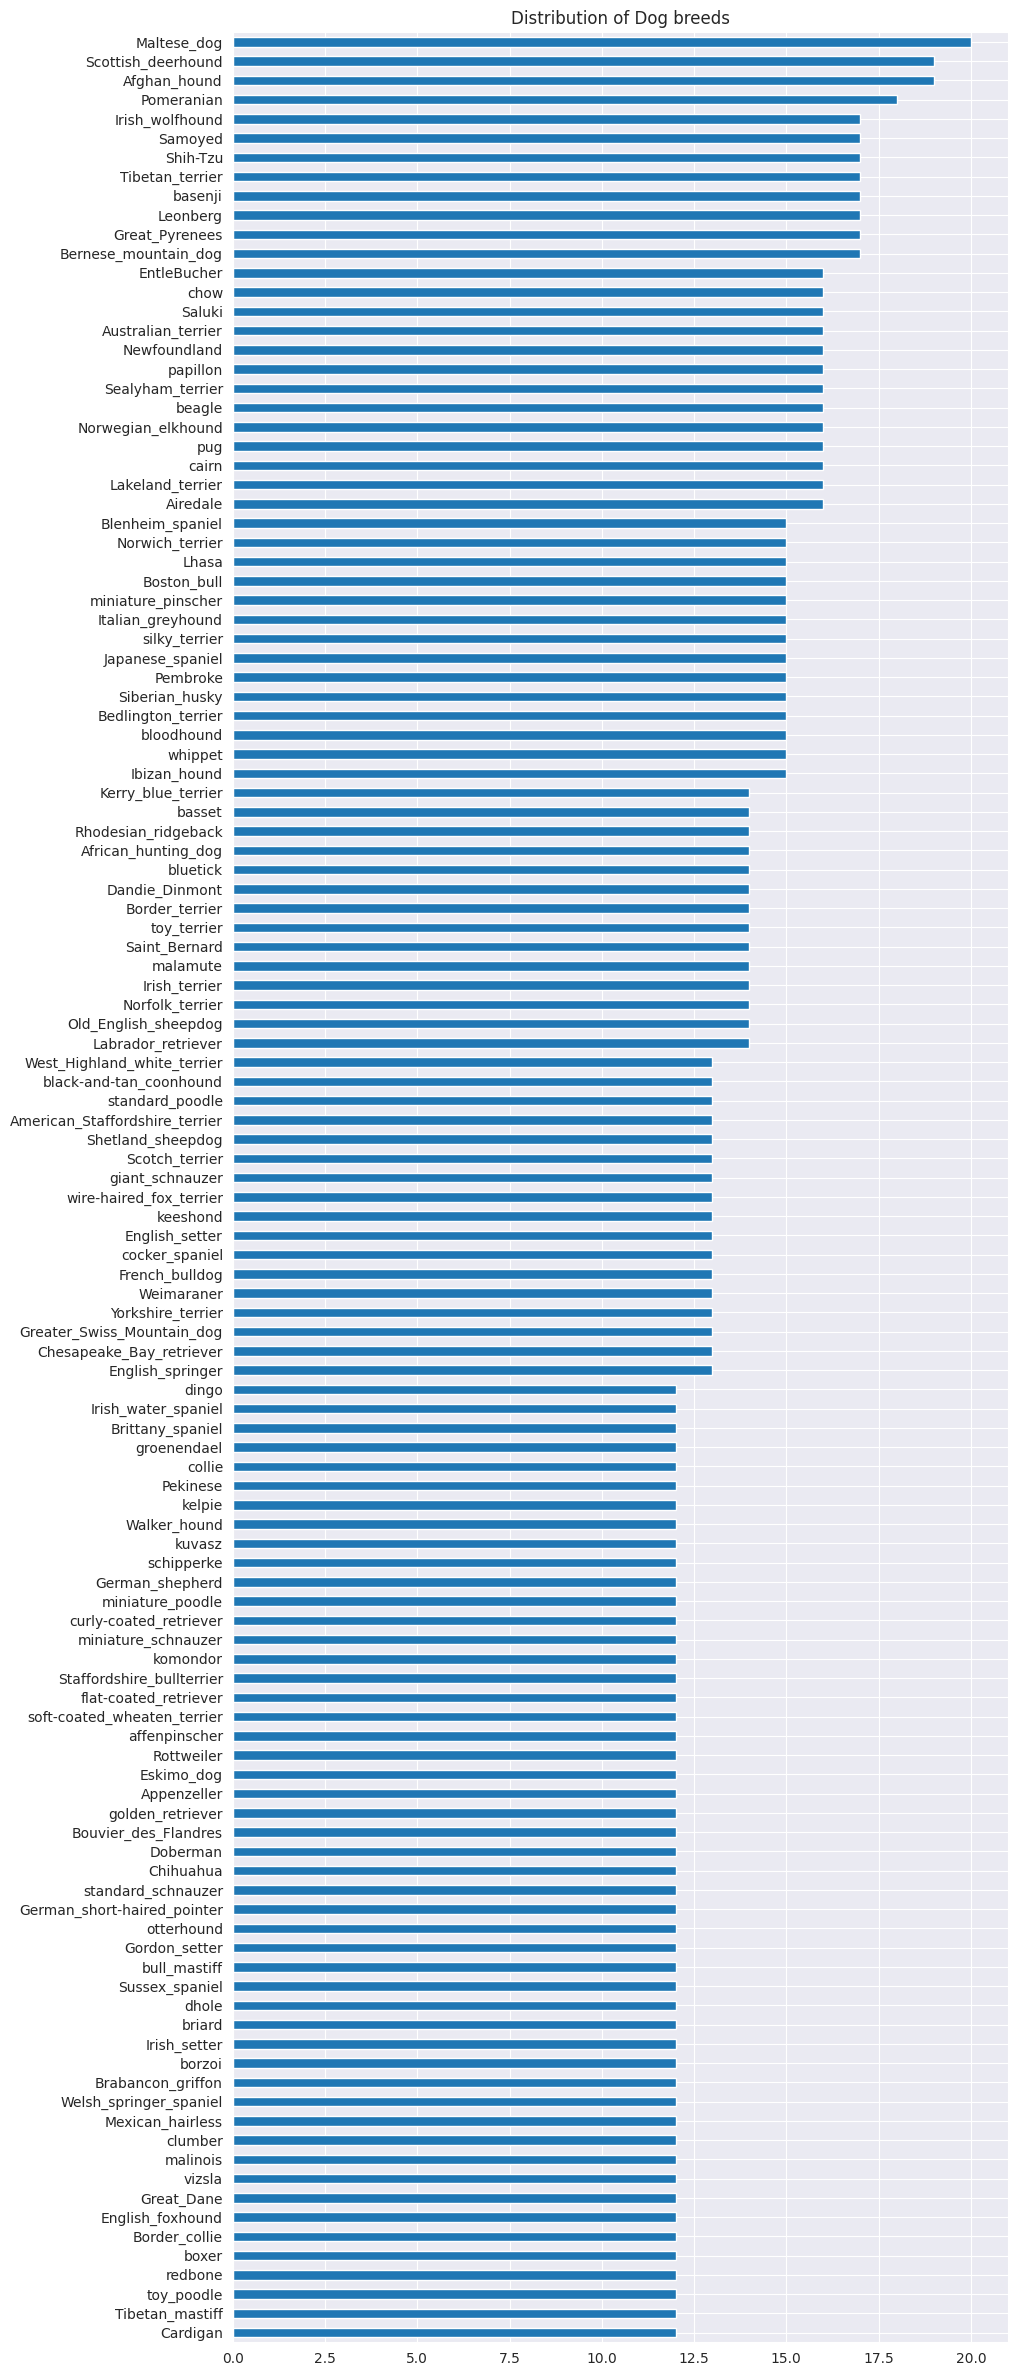

In [7]:
fig, ax = plt.subplots(figsize=(10,30))
valid_data['breed'].value_counts().plot(ax=ax, kind='barh').invert_yaxis()
ax.set_title('Distribution of Dog breeds')
plt.show()

In [8]:
fig, ax = plt.subplots(figsize=(10,30))
test_data['breed'].value_counts().plot(ax=ax, kind='barh').invert_yaxis()
ax.set_title('Distribution of Dog breeds')
plt.show()

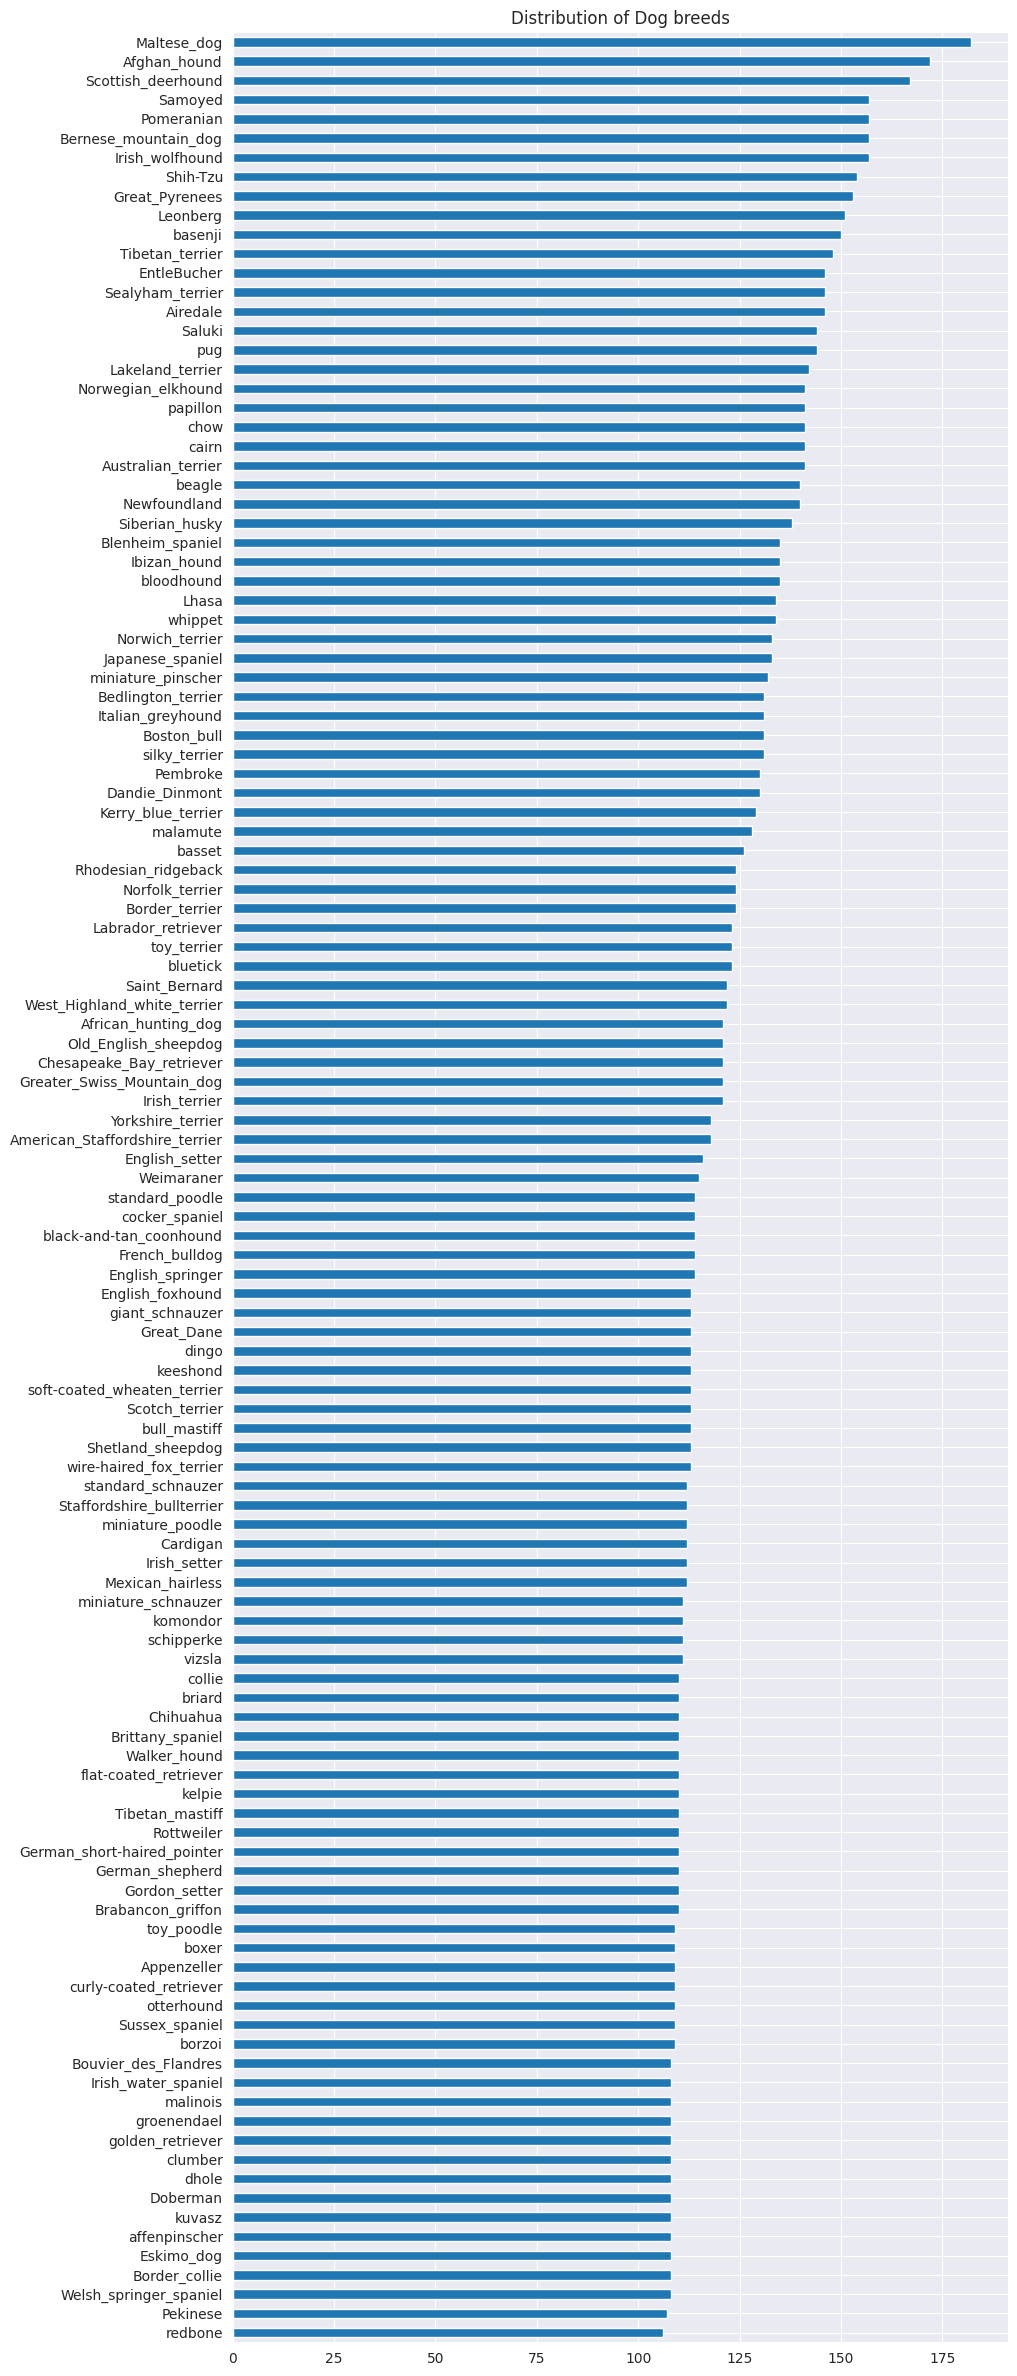

In [9]:
fig, ax = plt.subplots(figsize=(10,30))
train_data['breed'].value_counts().plot(ax=ax, kind='barh').invert_yaxis()
ax.set_title('Distribution of Dog breeds')
plt.show()

In [21]:
os.path.join(train_data['path'].values)

TypeError: expected str, bytes or os.PathLike object, not ndarray

In [41]:
for i, path in train_data['breed'].items():
    print(train_data.loc[i, "breed"])

English_foxhound
Australian_terrier
basset
Greater_Swiss_Mountain_dog
Samoyed
Pembroke
Great_Dane
dingo
otterhound
Old_English_sheepdog
cocker_spaniel
malamute
pug
Australian_terrier
miniature_pinscher
silky_terrier
whippet
Labrador_retriever
Ibizan_hound
Old_English_sheepdog
Saluki
Irish_water_spaniel
Shih-Tzu
Japanese_spaniel
malinois
basset
Tibetan_mastiff
groenendael
komondor
bluetick
Kerry_blue_terrier
Irish_terrier
Irish_water_spaniel
golden_retriever
German_shepherd
EntleBucher
clumber
malinois
giant_schnauzer
Rhodesian_ridgeback
Boston_bull
Norwegian_elkhound
Appenzeller
Norfolk_terrier
basenji
Leonberg
Lakeland_terrier
whippet
Walker_hound
Rhodesian_ridgeback
Doberman
Shetland_sheepdog
German_short-haired_pointer
Scottish_deerhound
schipperke
basenji
Shih-Tzu
miniature_poodle
Airedale
Australian_terrier
Japanese_spaniel
groenendael
black-and-tan_coonhound
whippet
Pembroke
Rhodesian_ridgeback
standard_poodle
Cardigan
Chesapeake_Bay_retriever
otterhound
Greater_Swiss_Mountain_do

In [51]:
import shutil


def copy_img(split_df, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for i, path in tqdm(split_df["path"].items()):
        label_folder = os.path.join(folder, split_df.loc[i, "breed"])
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        image_name = path.split(os.path.sep)[-1]
        destination = os.path.join(label_folder, image_name)
        shutil.copy(path, destination)


def copy_images(imagePaths, folder):
    # check if the destination folder exists and if not create it
    if not os.path.exists(folder):
        os.makedirs(folder)
    # loop over the image paths
    for path in imagePaths:
        # grab image name and its label from the path and create
        # a placeholder corresponding to the separate label folder
        imageName = path.split(os.path.sep)[-1]
        label = path.split(os.path.sep)[-2]
        labelFolder = os.path.join(folder, label)
        # check to see if the label folder exists and if not create it
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)
        # construct the destination image path and copy the current
        # image to it
        destination = os.path.join(labelFolder, imageName)
        shutil.copy(path, destination)

In [52]:
copy_img(train_data, "../42_split/train")
copy_img(valid_data, "../42_split/valid")
copy_img(test_data, "../42_split/test")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
def visualize_batch(batch, classes, dataset_type, BATCH_SIZE = 8):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
                     figsize=(BATCH_SIZE, BATCH_SIZE))
    # loop over the batch size
    for i in range(0, BATCH_SIZE):
        # create a subplot
        ax = plt.subplot(2, 4, i + 1)
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx]
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    # show the plot
    plt.tight_layout()
    plt.show()

In [26]:
print(train_data['path'].apply(lambda x : os.path.join(x)).head().values)

['../dataset/Images/n02089973-English_foxhound/n02089973_3480.jpg'
 '../dataset/Images/n02096294-Australian_terrier/n02096294_3899.jpg'
 '../dataset/Images/n02088238-basset/n02088238_12555.jpg'
 '../dataset/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_530.jpg'
 '../dataset/Images/n02111889-Samoyed/n02111889_774.jpg']


In [53]:
from PIL import Image
mean_std = datasets.ImageFolder(root = "../42_split/train",# loader=,
                                transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in tqdm(mean_std):
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(mean_std)
stds /= len(mean_std)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

  0%|          | 0/14817 [00:00<?, ?it/s]

Calculated means: tensor([0.4765, 0.4523, 0.3909])
Calculated stds: tensor([0.2335, 0.2287, 0.2271])


In [56]:
print(means.values)

<built-in method values of Tensor object at 0x7fb924af9c10>


In [57]:
pretrained_size = 224
pretrained_means = means
pretrained_stds= stds

train_transforms = transforms.Compose([
    transforms.Resize((pretrained_size, pretrained_size)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(pretrained_size, padding = 10),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means,
                         std = pretrained_stds)
])

test_transforms = transforms.Compose([
    transforms.Resize((pretrained_size, pretrained_size)),
    transforms.CenterCrop(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means,
                         std = pretrained_stds)
])

In [59]:
train_data = datasets.ImageFolder(root = "../42_split/train",
                                  transform = train_transforms)
valid_data = datasets.ImageFolder(root =  "../42_split/valid",
                                  transform = test_transforms)
test_data = datasets.ImageFolder(root =  "../42_split/test",
                                 transform = test_transforms)

In [60]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 14817
Number of validation examples: 1647
Number of testing examples: 4116


In [62]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [110]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(32, 1024)
        self.fc2 = nn.Linear(1024, 120)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [98]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]
        print(batch_size)
        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [104]:
INPUT_DIM = 32
OUTPUT_DIM = 120

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [92]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,581,470 trainable parameters


In [93]:
# optimizer = optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()

In [100]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [137]:
# class Net(nn.Module):
#     ''' Models a simple Convolutional Neural Network'''
#
#     def __init__(self):
#         ''' initialize the network '''
#         super(Net, self).__init__()
#         # 3 input image channel, 6 output channels,
#         # 5x5 square convolution kernel
#         self.conv1 = nn.Conv2d(3, 6, 224)
#         # Max pooling over a (2, 2) window
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 32, 224)
#         self.fc1 = nn.Linear(32 * 224 * 224, 120)# 5x5 from image dimension
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 120)
#
#     def forward(self, x):
#         ''' the forward propagation algorithm '''
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 32 * 224 * 224)
#         # h = x.view(x.shape[0], -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [138]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(224, 224), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 32, kernel_size=(224, 224), stride=(1, 1))
  (fc1): Linear(in_features=1605632, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=120, bias=True)
)


In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 80, 1, stride=1),
    nn.ReLU(),
    nn.Conv2d(80, 40, 1, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(4, stride=1),
    nn.Conv2d(40, 30, 1, stride=1),
    nn.ReLU(),
    nn.Conv2d(30, 15, 1, stride=1),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(253*253*15, 256),
    nn.Dropout(0.1),
    nn.Linear(256, 120),
    nn.ReLU()
)

In [144]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.adapt = nn.AdaptiveMaxPool2d((5,7))
        self.fc1 = nn.Linear(16*5*7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 120)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.adapt(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [149]:
def find_settings(shape_in, shape_out, kernel_sizes, dilation_sizes, padding_sizes, stride_sizes, transpose=False):
    from itertools import product

    import torch
    from torch import nn

    import numpy as np

    # Fake input
    x_in = torch.tensor(np.random.randn(4, 1, shape_in, shape_in), dtype=torch.float)

    # Grid search through all combinations
    for kernel, dilation, padding, stride in product(kernel_sizes, dilation_sizes, padding_sizes, stride_sizes):
        # Define a layer
        if transpose:
            layer = nn.ConvTranspose2d
        else:
            layer = nn.Conv2d
        layer = layer(
            1, 1,
            (4, kernel),
            stride=(2, stride),
            padding=(2, padding),
            dilation=(2, dilation)
        )

        # Check if layer is valid for given input shape
        try:
            x_out = layer(x_in)
        except Exception:
            continue

        # Check for shape of out tensor
        result = x_out.shape[-1]

        if shape_out == result:
            print('Correct shape for:\n ker: {}\n dil: {}\n pad: {}\n str: {}\n'.format(kernel, dilation, padding, stride))

transpose = True
shape_in = 224
shape_out = 1024


kernel_sizes = [3, 4, 5, 7, 9, 11]
dilation_sizes = list(range(1, 20))
padding_sizes = list(range(15))
stride_sizes = list(range(4, 16))
find_settings(shape_in, shape_out, kernel_sizes, dilation_sizes, padding_sizes, stride_sizes, transpose)

In [146]:
model = Net().to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
model.train()

for (x, y) in tqdm(train_iterator, desc="Training", leave=False):

    x = x.to("cpu")
    y = y.to("cpu")

    optimizer.zero_grad()

    y_pred = model(x)

    loss = criterion(y_pred, y)

    acc = calculate_accuracy(y_pred, y)

    loss.backward()

    optimizer.step()

Training:   0%|          | 0/464 [00:00<?, ?it/s]

In [95]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [96]:
# SEED = 1234
# import random
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [97]:
EPOCHS = 10
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/464 [00:00<?, ?it/s]

32


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x150528 and 50176x250)